# Topic Modeling
Topic modeling is necessary so that news articles can be grouped by topic. This will provide additional ways to filter through the articles within the app.

In [60]:
import pandas as pd
from sqlalchemy import create_engine
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel # for evaluating LDA model
import matplotlib.pyplot as plt
import json
import re

In [2]:
# only need to run this once
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/markus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
with open('../secrets.json') as file:
    secrets = json.load(file)
    connection_string = secrets['connection_string']
db = create_engine(connection_string)
df = pd.read_sql('select * from news_article', con=db)

### code for exporting data from AWS database
This was only needed once to move the data to the new database so this can be ignored

In [4]:
# df['date_published'].ffill(inplace=True)
# df = df.drop(columns='id')
# df = df[df['content'].str.len() > 0]
# df = df[df['headline'].str.len() > 0]
# df.to_csv('articles.csv', index=False)

### Get the content of the articles

In [5]:
# article1 = df.iloc[-1]['content']
# article2 = df.iloc[-2]['content']
# articles = [article1, article2]
articles = [df.iloc[i]['content'] for i in range(len(df))]

### Get words from the article

In [6]:
# tokens = word_tokenize(article)
# text = nltk.Text(tokens)
# text

### Show the collacations
These are words that appeared consecutively in the text. More specifically, words that appear consecutively and not by chance, so they have meaning when put together.

In [7]:
# text.collocations()

### Tokenize, lemmatize, remove stopwords, stem and discard words fewer than 3 chars
- Tokenization involves splitting the article into words.
- Lemmatization is getting words into a standard form. Words in third person are changed to first person and verbs are converted to present tense.
    - ex: disapperances -> disappearance
- Stemming is reducing words to their root form. This also converts all words to lower case.
    - ex: disappearance -> disappear
- Stopwords are words like "the", "a", "an", etc.

In [8]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [9]:
def preprocess(article):
    tokens = word_tokenize(article.lower()) # make all articles lower case
    words = [] # words resulting from applying the filters

    for token in tokens:
        if len(token) > 3 and token not in stop_words:
            words.append(lemmatizer.lemmatize(token))
    
    return words

In [10]:
preprocessed_articles = [preprocess(article) for article in articles]
# preprocessed_articles

### Create a dictionary of text and bag of words
A bag of words is a list of tuples of the form (token id, count of token)

In [11]:
dictionary = Dictionary(preprocessed_articles)
corpus = [dictionary.doc2bow(article) for article in preprocessed_articles]

# for each tuple in the corpus, the first element is the word index and the second element
# is the number of times it appears in the text
# for c in corpus:
#     for item in c:
#         print(f'{item} -- {dictionary[item[0]]}')

### Create the LDA model for topic modeling
This trains a model and creates however many topics are specified. It doesn't assign names to the topics, so these need to be inferred.

In [12]:
# this model didn't have the best coherence score, but in my opinion it produces the best topics
model = LdaMulticore(corpus, num_topics=4, id2word=dictionary, passes=10, workers=2, chunksize=100)

### Structure the topics as a dict and parse out the words for each topic

In [13]:
model.print_topics()

[(0,
  '0.014*"2020" + 0.008*"police" + 0.008*"picture" + 0.007*"news" + 0.007*"getty" + 0.006*"protester" + 0.005*"protest" + 0.005*"image" + 0.005*"area" + 0.005*"bolsonaro"'),
 (1,
  '0.016*"said" + 0.005*"people" + 0.005*"police" + 0.005*"state" + 0.005*"government" + 0.004*"president" + 0.004*"right" + 0.004*"also" + 0.004*"country" + 0.004*"trump"'),
 (2,
  '0.013*"said" + 0.008*"year" + 0.006*"company" + 0.005*"world" + 0.005*"also" + 0.004*"would" + 0.004*"climate" + 0.004*"country" + 0.004*"global" + 0.003*"china"'),
 (3,
  '0.016*"said" + 0.010*"people" + 0.008*"covid-19" + 0.008*"health" + 0.007*"coronavirus" + 0.007*"case" + 0.005*"virus" + 0.005*"country" + 0.005*"government" + 0.005*"pandemic"')]

In [14]:
raw_topics = model.print_topics()
topics = {}

for topic in raw_topics:
    topic_no = topic[0]
    topic_words = topic[1].split('+')
    
    # find words using regex and remove double quotes
    topic_words = [re.search('\".+\"', words).group().replace('"', '') for words in topic_words]
    
    # add topic_no and words to topics
    topics.update({topic_no: topic_words})

### Display the topics

In [15]:
for key in topics.keys():
    print(f'topic {key}')
    print(topics[key])
    print()

topic 0
['2020', 'police', 'picture', 'news', 'getty', 'protester', 'protest', 'image', 'area', 'bolsonaro']

topic 1
['said', 'people', 'police', 'state', 'government', 'president', 'right', 'also', 'country', 'trump']

topic 2
['said', 'year', 'company', 'world', 'also', 'would', 'climate', 'country', 'global', 'china']

topic 3
['said', 'people', 'covid-19', 'health', 'coronavirus', 'case', 'virus', 'country', 'government', 'pandemic']



### Topics
0. social
1. government/politics
2. science
3. coronavirus

### Save the model to a file
only uncomment this when you find a model you want to save

In [69]:
# model.save('models/news_lda_model')

### Making predictions with the trained model

In [17]:
# test_article = df.iloc[84]['content'] # gov
# test_article = df.iloc[3238]['content'] # tech
# test_article = df.iloc[5592]['content'] # science
# test_article = df.iloc[1339]['content'] # science
# test_article = df.iloc[4992]['content'] # business
test_article = df.iloc[5626]['content']

### Function to get predicted topic for an article

In [56]:
def predict_topic(art):
    preprocessed = preprocess(art)
    
    # create bag of words
    # model.id2word is the dictionary that was used to train the model
    # this is useful so that I don't have to pickle the dictionary separately
    bow = model.id2word.doc2bow(preprocessed)
    
    # make the prediciton
    pred = model[bow]
    
    predicted_topic = pred[0][0]
    best_match = pred[0][1]

    for p in pred:
        if p[1] > best_match:
            predicted_topic = p[0]
            best_match = p[1]
            
    return predicted_topic

### See how many articles are in each topic

In [58]:
counts = {
    0: 0,
    1: 0,
    2: 0,
    3: 0
}

for i in range(len(df)):
    pred = predict_topic(df.iloc[i]['content'])
    counts[pred] += 1
    
for key in counts.keys():
    print(f'{key}: {counts[key]}')

0: 239
1: 2504
2: 1329
3: 1568


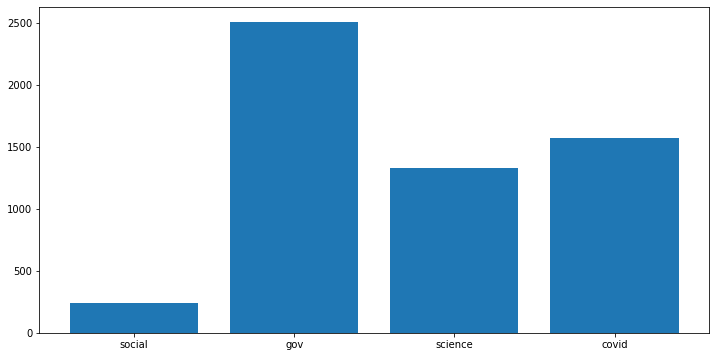

In [67]:
# plot the number of articles in each topic
plt.figure(figsize=(12, 6))
plt.bar(['social', 'gov', 'science', 'covid'], [counts[key] for key in counts.keys()])
plt.show()

In [70]:
# df[df['content'].str.contains('climate')]

### some helpful methods to use with the model

In [24]:
# show topics for a specific document
model.get_document_topics(bow)

[(2, 0.99643993)]

In [25]:
# get probability of each word in each topic
model.get_topics()

array([[1.2169720e-04, 1.6296956e-06, 1.7417744e-06, ..., 1.5604569e-06,
        2.4599276e-05, 2.4599276e-05],
       [1.5078865e-05, 1.8204784e-04, 1.4297725e-04, ..., 3.3755969e-06,
        4.1952080e-07, 4.1952080e-07],
       [9.7456606e-05, 2.8295140e-03, 8.1273686e-04, ..., 5.1915094e-07,
        5.1915958e-07, 5.1915958e-07],
       [4.2005084e-04, 1.0385923e-03, 8.1222726e-04, ..., 5.6263173e-07,
        6.2583047e-07, 6.2583047e-07]], dtype=float32)

In [26]:
# Show top words for a specific topic.
# I believe the number along with each word is the probability that a document would be part
# of that topic if it contained that word, but I would need to double check that in the docs.
model.show_topic(1, topn=20)

[('said', 0.016356008),
 ('people', 0.0050282176),
 ('police', 0.004876252),
 ('state', 0.004521574),
 ('government', 0.0045206775),
 ('president', 0.004482007),
 ('right', 0.0043196524),
 ('also', 0.004290839),
 ('country', 0.003883938),
 ('trump', 0.0038731403),
 ('year', 0.003796118),
 ('would', 0.0036867552),
 ('china', 0.0033694378),
 ('report', 0.003089808),
 ('official', 0.0030810784),
 ('security', 0.003073313),
 ('group', 0.0030534498),
 ('russia', 0.0029911557),
 ('military', 0.0028998563),
 ('told', 0.002898611)]

In [27]:
# Show each topic and it's coherence score. This will be useful for evaluating the model.
model.top_topics(corpus)

[([(0.01635176, 'said'),
   (0.010475212, 'people'),
   (0.0080264695, 'covid-19'),
   (0.008007401, 'health'),
   (0.00713907, 'coronavirus'),
   (0.0069018635, 'case'),
   (0.005034241, 'virus'),
   (0.0049920958, 'country'),
   (0.0048570163, 'government'),
   (0.0045126635, 'pandemic'),
   (0.0044119474, 'would'),
   (0.0043228096, 'death'),
   (0.004090674, 'vaccine'),
   (0.0040221303, 'home'),
   (0.003977135, 'first'),
   (0.003812066, 'week'),
   (0.0037886081, 'also'),
   (0.003548614, 'time'),
   (0.0034912226, 'hospital'),
   (0.0033957043, 'public')],
  -0.9249449567568429),
 ([(0.01635601, 'said'),
   (0.005028218, 'people'),
   (0.0048762523, 'police'),
   (0.0045215744, 'state'),
   (0.004520678, 'government'),
   (0.0044820076, 'president'),
   (0.004319653, 'right'),
   (0.0042908397, 'also'),
   (0.0038839385, 'country'),
   (0.0038731408, 'trump'),
   (0.0037961185, 'year'),
   (0.0036867557, 'would'),
   (0.0033694382, 'china'),
   (0.0030898084, 'report'),
   (0.0

### Model evaluation

In [49]:
# create several LDA models with different k values
model1 = LdaMulticore(corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)
model2 = LdaMulticore(corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)
model3 = LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)
model4 = LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=2, workers=2)
model5 = LdaMulticore(corpus, num_topics=7, id2word=dictionary, passes=2, workers=2)
model6 = LdaMulticore(corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

In [50]:
# create coherence models to evaluate each LDA model
cm1 = CoherenceModel(model=model1, corpus=corpus, coherence='u_mass')
cm2 = CoherenceModel(model=model2, corpus=corpus, coherence='u_mass')
cm3 = CoherenceModel(model=model3, corpus=corpus, coherence='u_mass')
cm4 = CoherenceModel(model=model4, corpus=corpus, coherence='u_mass')
cm5 = CoherenceModel(model=model5, corpus=corpus, coherence='u_mass')
cm6 = CoherenceModel(model=model6, corpus=corpus, coherence='u_mass')

In [51]:
# show the coherence score for each model, the score closest to 0 is the best model
print(f'3 topics: {cm1.get_coherence()}')
print(f'4 topics: {cm2.get_coherence()}')
print(f'5 topics: {cm3.get_coherence()}')
print(f'6 topics: {cm4.get_coherence()}')
print(f'7 topics: {cm5.get_coherence()}')
print(f'8 topics: {cm6.get_coherence()}')

3 topics: -0.956437725415844
4 topics: -0.9895622166086868
5 topics: -1.0383314901683396
6 topics: -1.0201118639199547
7 topics: -1.016463196118569
8 topics: -1.0812588447431652


In [55]:
# show the topics of the best model
model2.print_topics()

[(0,
  '0.013*"said" + 0.006*"people" + 0.005*"police" + 0.004*"would" + 0.004*"also" + 0.004*"year" + 0.003*"country" + 0.003*"government" + 0.003*"state" + 0.003*"could"'),
 (1,
  '0.007*"said" + 0.005*"people" + 0.005*"government" + 0.004*"also" + 0.004*"year" + 0.004*"world" + 0.003*"news" + 0.003*"state" + 0.003*"time" + 0.003*"country"'),
 (2,
  '0.016*"said" + 0.005*"country" + 0.005*"people" + 0.004*"year" + 0.004*"would" + 0.004*"china" + 0.004*"coronavirus" + 0.004*"also" + 0.004*"world" + 0.003*"vaccine"'),
 (3,
  '0.015*"said" + 0.005*"people" + 0.005*"government" + 0.004*"also" + 0.004*"year" + 0.003*"would" + 0.003*"navalny" + 0.003*"trump" + 0.003*"state" + 0.003*"time"')]